In this notebook, I created a time series model to predict daily climate. The data processing sections include Data Cleaning, Feature Engineering, Time Series Creation, and Exploratory Data Analysis (EDA).

Michael Barajas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV

# Functions

In [2]:
#This function considers outliers as values that are greater than twice the 99th percentile value 
#and values that are less than half of the 1st percentile value.
def outliers(df):
    descriptive_stats = df.describe(percentiles=[0.01, 0.99])
    higher_99 = []
    lower_01 = []
    
    # Identificar columnas con valores mayores al percentil 99 o menores al percentil 01
    for col in df.columns:
        max_val = descriptive_stats.loc['max', col]
        percentile_99 = descriptive_stats.loc['99%', col]
        min_val = descriptive_stats.loc['min', col]
        percentile_01 = descriptive_stats.loc['1%', col]
    
        if max_val > 2 * percentile_99:
            higher_99.append(col)
    
        if min_val < percentile_01 / 2:
            lower_01.append(col)
    
    print("Variables cuyo máximo es mayor al doble del percentil 99:", higher_99)
    print("Variables cuyo mínimo es menor a la mitad del percentil 01:", lower_01)
    
    # Filtrar filas con valores atípicos
    for col in higher_99:
        threshold = descriptive_stats.loc['99%', col]
        df = df[df[col] <= threshold]
    
    for col in lower_01:
        threshold = descriptive_stats.loc['1%', col]
        df = df[df[col] >= threshold]
    
    return df

# Data

In [3]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')

In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Feature Engineering

In [5]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week #week of the year

In [8]:
df.sample(5)

,date,meantemp,humidity,wind_speed,meanpressure,month,week
31,2013-02-01,16.000000,73.000000,2.220000,1016.000000,2,5
1261,2016-06-15,34.733333,48.866667,10.513333,996.133333,6,24
758,2015-01-29,11.500000,67.500000,3.937500,1019.750000,1,5
306,2013-11-03,20.625000,57.875000,5.562500,1016.000000,11,44
1298,2016-07-22,34.125000,56.125000,8.687500,999.333333,7,29


In [9]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'month',
       'week'],
      dtype='object')

In [10]:
cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'month', 'week']

# Data Cleaning

## Missings

In [11]:
df.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
month           0
week            0
dtype: int64

## Outliers

In [12]:
df[cols].describe(percentiles=[0.01, 0.02, 0.05, 0.50, 0.95, 0.98, 0.99])

,meantemp,humidity,wind_speed,meanpressure,month,week
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.0
mean,25.495521,60.771702,6.802209,1011.104548,6.519152,26.644323
std,7.348103,16.769652,4.561602,180.231668,3.451727,15.079054
min,6.000000,13.428571,0.000000,-3.041667,1.000000,1.0
1%,9.951250,22.217500,0.000000,994.201250,1.000000,1.0
2%,11.190250,23.726917,0.462500,995.268333,1.000000,2.0
5%,12.506250,29.000000,0.925000,996.833333,1.000000,3.0
50%,27.714286,62.625000,6.221667,1008.563492,7.000000,27.0
95%,35.428571,86.991667,14.812500,1019.329167,12.000000,50.0
98%,36.875000,91.208000,17.890000,1020.613214,12.000000,52.0


In [13]:
clean_df = outliers(df[cols])
df = df.loc[clean_df.index]

Variables cuyo máximo es mayor al doble del percentil 99: ['wind_speed', 'meanpressure']
Variables cuyo mínimo es menor a la mitad del percentil 01: ['meanpressure']


# EDA

C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

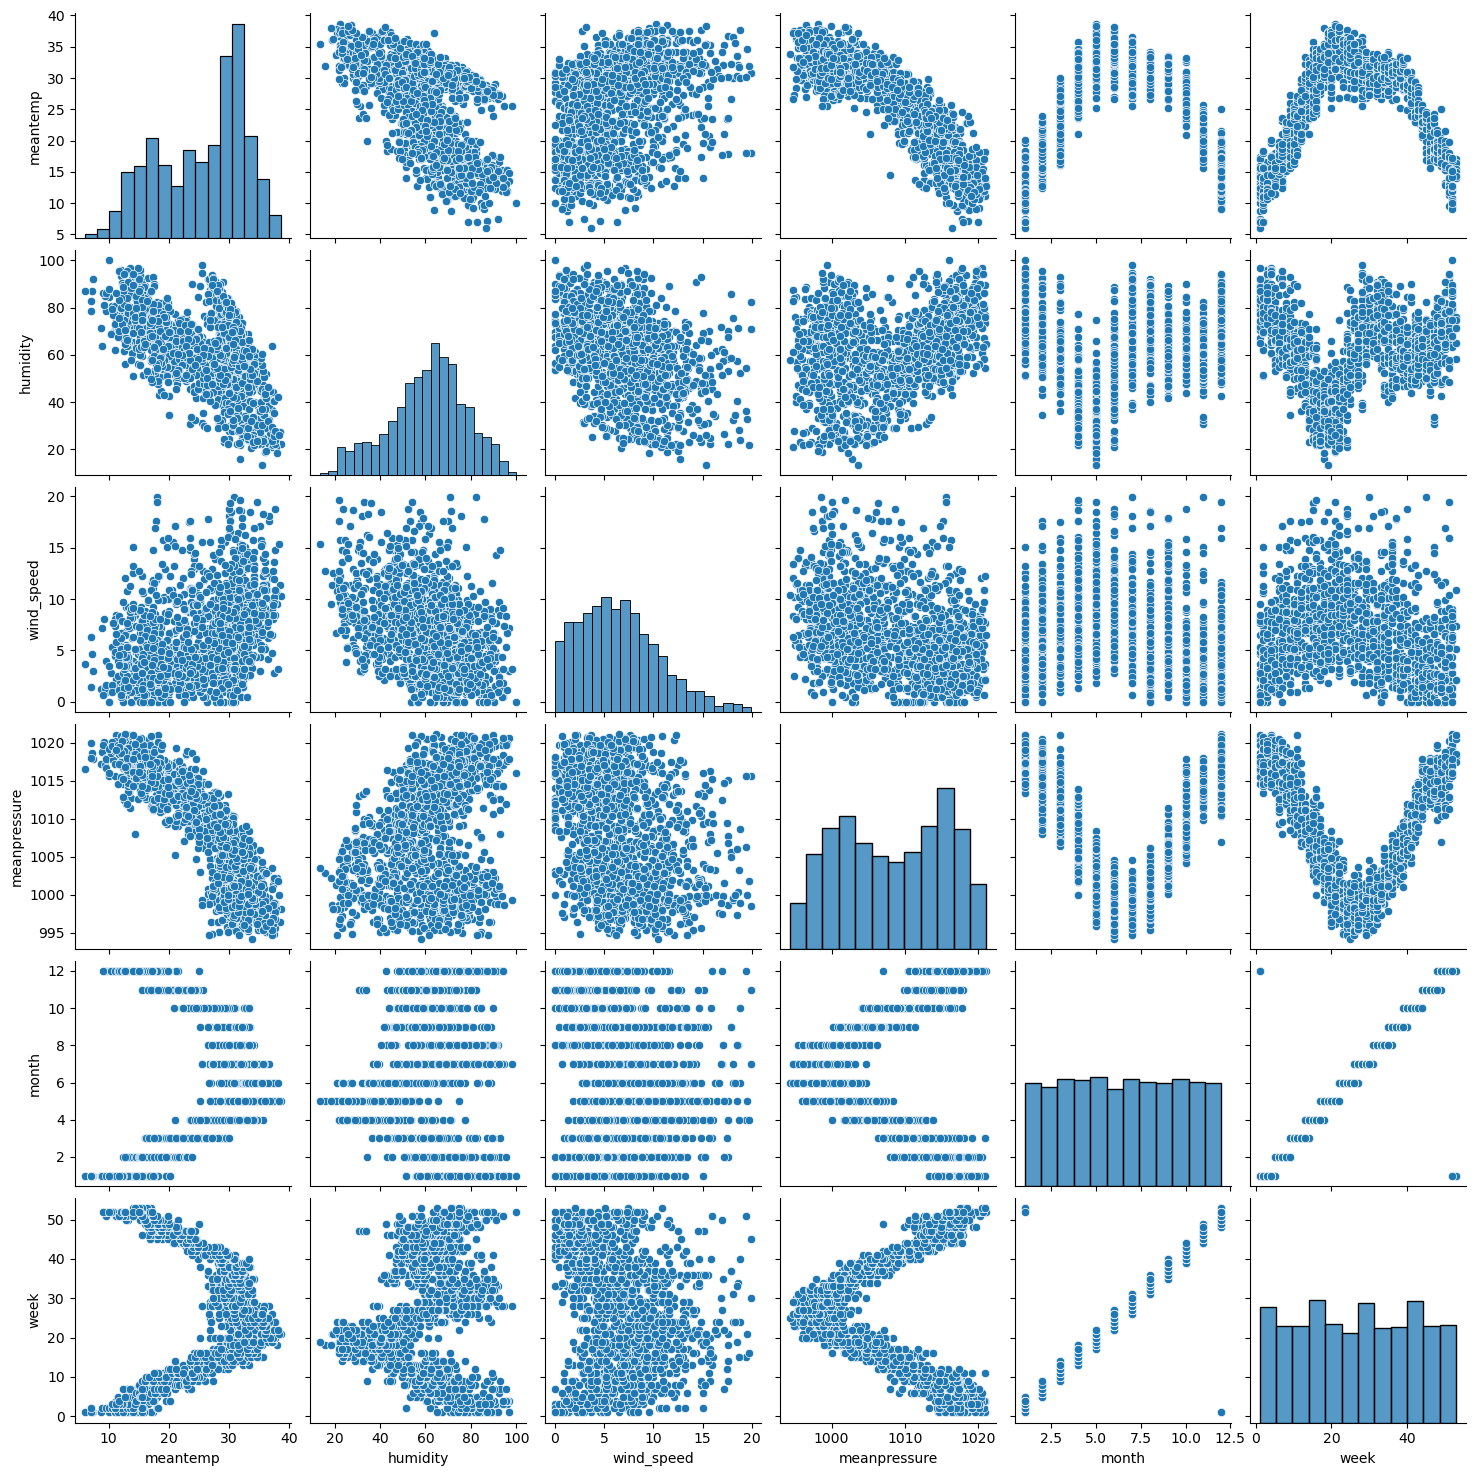

In [14]:
sns.pairplot(df[cols])

In [15]:
df.corr()

,date,meantemp,humidity,wind_speed,meanpressure,month,week
date,1.000000,0.127901,-0.049906,-0.014521,0.016690,0.243580,0.248292
meantemp,0.127901,1.000000,-0.566650,0.348318,-0.873935,0.124982,0.129810
humidity,-0.049906,-0.566650,1.000000,-0.406813,0.313005,0.080014,0.080838
wind_speed,-0.014521,0.348318,-0.406813,1.000000,-0.331968,-0.188162,-0.186355
meanpressure,0.016690,-0.873935,0.313005,-0.331968,1.000000,-0.088302,-0.089777
month,0.243580,0.124982,0.080014,-0.188162,-0.088302,1.000000,0.965241
week,0.248292,0.129810,0.080838,-0.186355,-0.089777,0.965241,1.000000


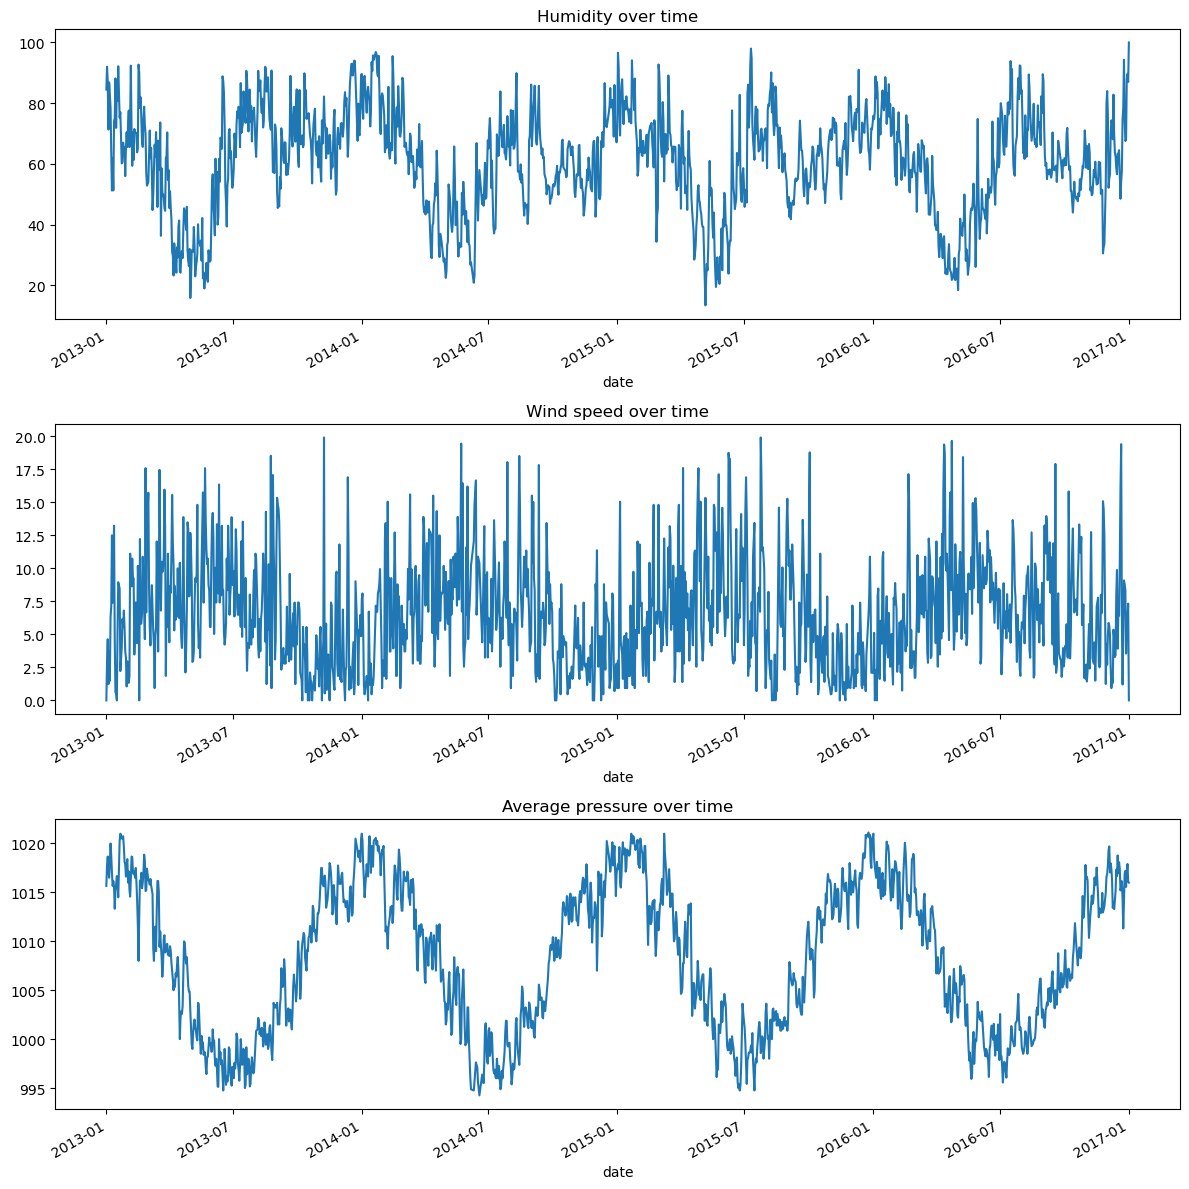

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
df.set_index('date')['humidity'].plot(ax=ax[0], title='Humidity over time')
df.set_index('date')['wind_speed'].plot(ax=ax[1], title='Wind speed over time')
df.set_index('date')['meanpressure'].plot(ax=ax[2], title='Average pressure over time')
plt.tight_layout()
plt.show()


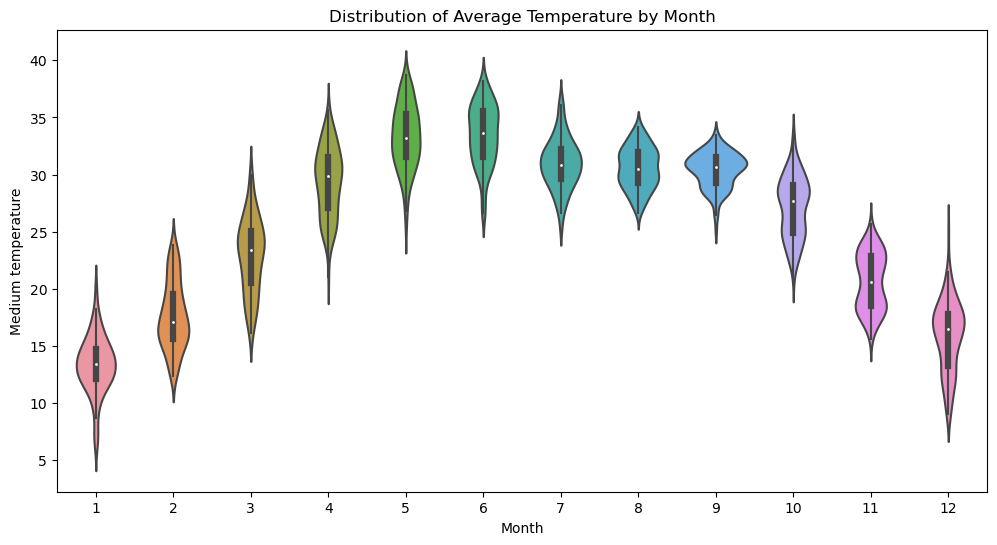

In [17]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='month', y='meantemp', data=df)
plt.title('Distribution of Average Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Medium temperature')
plt.show()

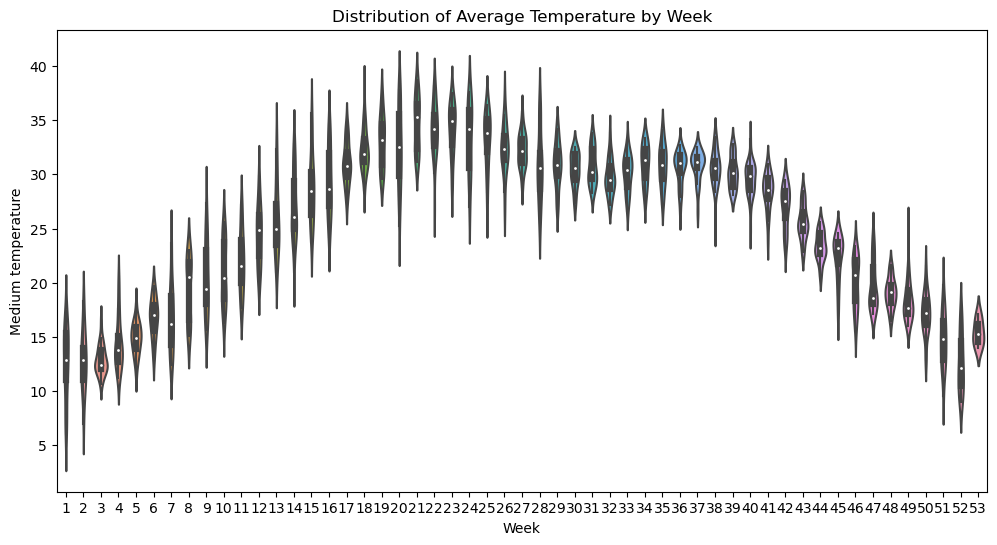

In [18]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='week', y='meantemp', data=df)
plt.title('Distribution of Average Temperature by Week')
plt.xlabel('Week')
plt.ylabel('Medium temperature')
plt.show()

In [19]:
df = pd.get_dummies(df, columns=['month', 'week'], drop_first=True, dtype=int)

# Model

In [20]:
df['y'] = df['meantemp'].shift(1)
df.dropna(inplace=True)

In [21]:
X = df.drop(columns=['date', 'meantemp','y'])
y = df['y']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {loss}")

Epoch 1/50
80/80 [==============================] - 0s 2ms/step - loss: 479.2777 - val_loss: 177.5563
Epoch 2/50
80/80 [==============================] - 0s 677us/step - loss: 49.7740 - val_loss: 8.8072
Epoch 3/50
80/80 [==============================] - 0s 671us/step - loss: 6.9431 - val_loss: 4.9988
Epoch 4/50
80/80 [==============================] - 0s 677us/step - loss: 5.0874 - val_loss: 4.6650
Epoch 5/50
80/80 [==============================] - 0s 633us/step - loss: 4.7635 - val_loss: 4.5617
Epoch 6/50
80/80 [==============================] - 0s 614us/step - loss: 4.6515 - val_loss: 4.4634
Epoch 7/50
80/80 [==============================] - 0s 620us/step - loss: 4.5811 - val_loss: 4.4890
Epoch 8/50
80/80 [==============================] - 0s 623us/step - loss: 4.4921 - val_loss: 4.3534
Epoch 9/50
80/80 [==============================] - 0s 671us/step - loss: 4.4375 - val_loss: 4.2941
Epoch 10/50
80/80 [==============================] - 0s 665us/step - loss: 4.4283 - val_loss: 4.3

In [26]:
y_pred = model.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

14/14 [==============================] - 0s 384us/step
         Actual  Predicted
54    17.428571  17.928324
493   31.375000  33.007927
835   27.625000  25.369291
1298  34.133333  32.428764
303   22.857143  24.103662


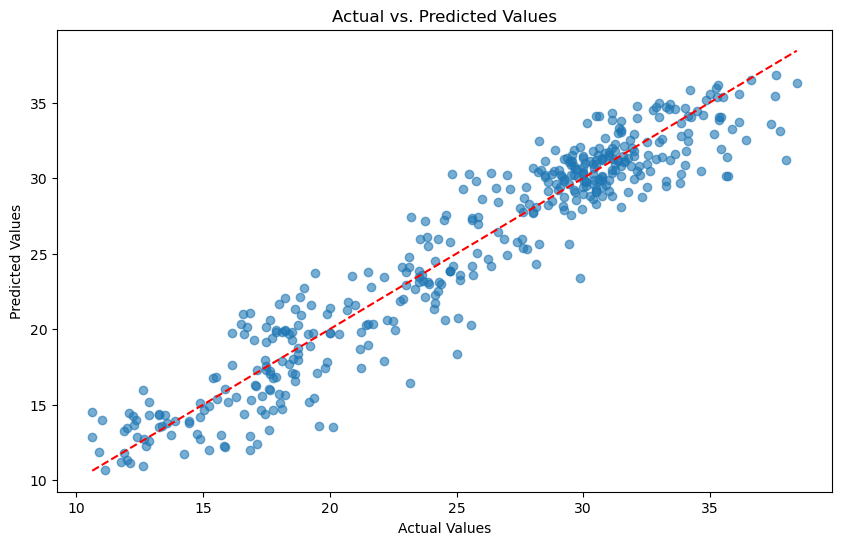

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

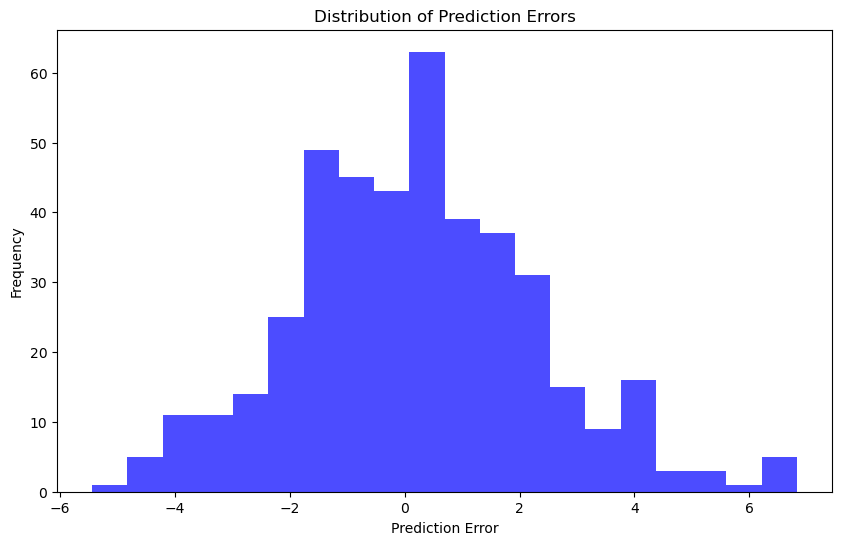

In [28]:
errors = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()